# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

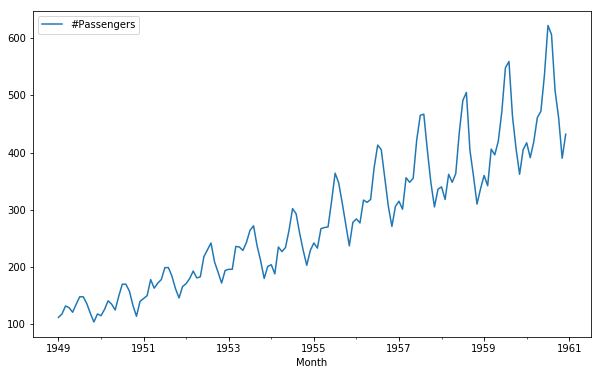

In [1]:
# Import necessary libraries
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# Import passengers.csv and set it as a time-series object. Plot the TS
df = pd.read_csv('passengers.csv')
ts = df.set_index('Month')
ts.index = pd.to_datetime(ts.index)
ts.plot(figsize=(10,6));

## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [5]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab
def stationarity_check(TS):
    from statsmodels.tsa.stattools import adfuller

    rollingmean = TS.rolling(window = 8, center = False).mean()
    rollingstd = TS.rolling(window = 8, center = False).std()

    dftest = adfuller(TS['#Passengers'])

    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='black',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    std = plt.plot(rollingstd, color='green', label = 'Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & St')
    plt.show(block=False)

    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags','Observations'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

Use your newly created function on the airpassenger data set.

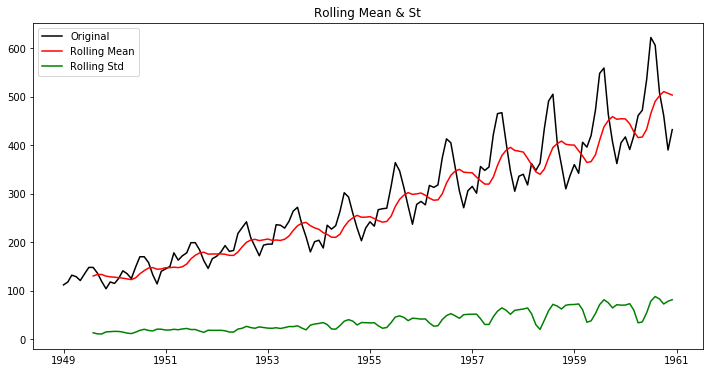

Results of Dickey-Fuller Test:
Test Statistic            0.815369
p-value                   0.991880
Lags                     13.000000
Observations            130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [6]:
# Code here
stationarity_check(ts)

## Perform a log() and sqrt() transform

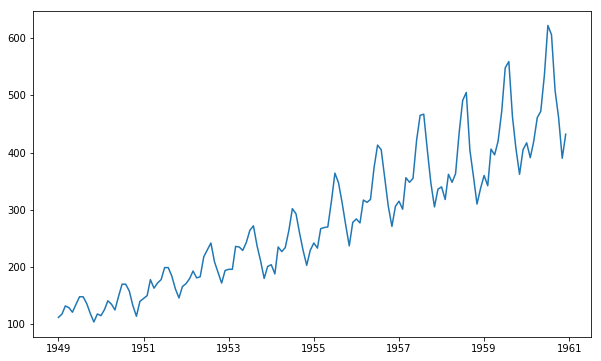

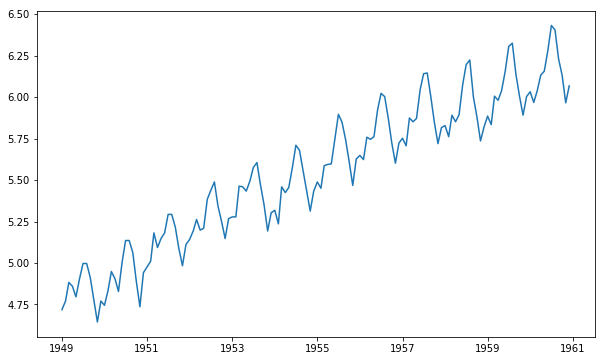

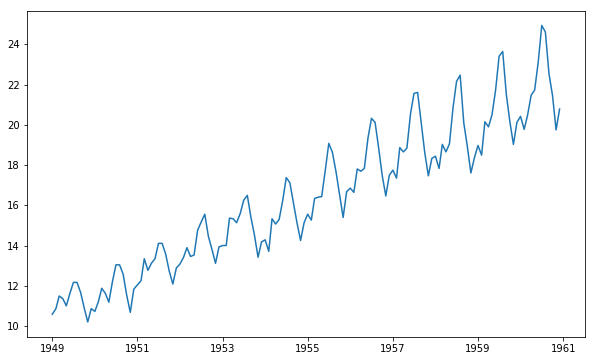

In [7]:

tslog = np.log(ts)
tssqrt= np.sqrt(ts)
fig = plt.figure(figsize=(10,6))
plt.plot(ts);
plt.show()
fig = plt.figure(figsize=(10,6))
plt.plot(tslog);
plt.show()
fig = plt.figure(figsize=(10,6))
plt.plot(tssqrt);


moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

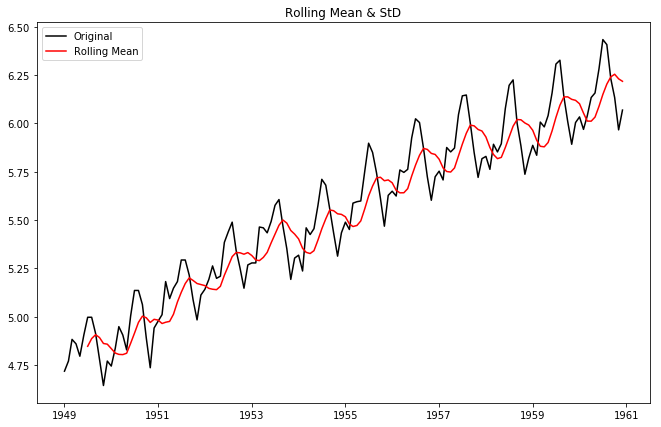

In [8]:
# your code here
rollingmean = np.log(ts).rolling(window = 7).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(np.log(ts), color='black',label='Original')
mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
plt.legend()
plt.title('Rolling Mean & StD')
plt.show(block=False)

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [9]:
# Subtract the moving average from the original data and check head for Nans
dfsub = np.log(ts) - rollingmean
dfsub.head(10)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,0.150059
1949-08-01,0.110242
1949-09-01,0.005404


In [10]:
# Drop the NaN values from timeseries calculated above
dfsub.dropna(inplace=True)

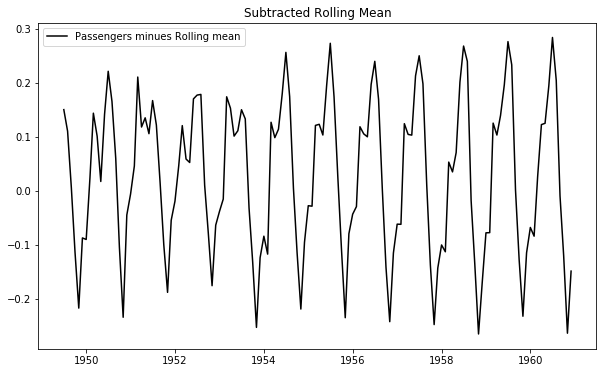

In [11]:
# Plot the result
fig = plt.figure(figsize=(10,6))
plt.plot(dfsub, color='black',label='Passengers minues Rolling mean')
plt.legend()
plt.title('Subtracted Rolling Mean')
plt.show(block=False)

Finally, use your function `check_stationarity` to see if this series is considered stationary!

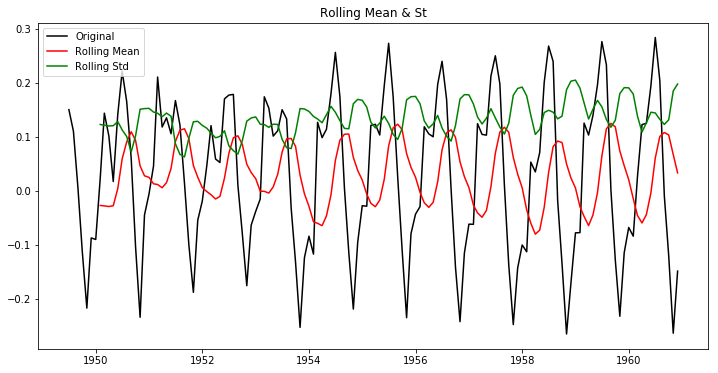

Results of Dickey-Fuller Test:
Test Statistic           -2.348027
p-value                   0.156946
Lags                     14.000000
Observations            123.000000
Critical Value (1%)      -3.484667
Critical Value (5%)      -2.885340
Critical Value (10%)     -2.579463
dtype: float64


In [12]:
# Your code here
stationarity_check(dfsub)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?
P val is higher than critical value so we cannot reject the null hypothesis to confidently say the series is stationary.

## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

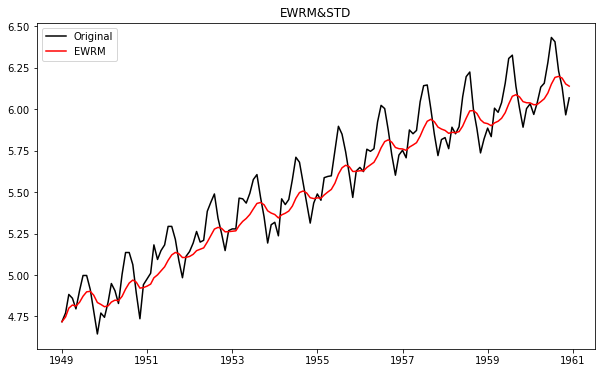

In [13]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
rollingmeanexp = np.log(ts).ewm(halflife = 4).mean()
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(np.log(ts), color='black',label='Original')
mean = plt.plot(rollingmeanexp, color='red', label='EWRM')
plt.legend()
plt.title('EWRM&STD')
plt.show(block=False)

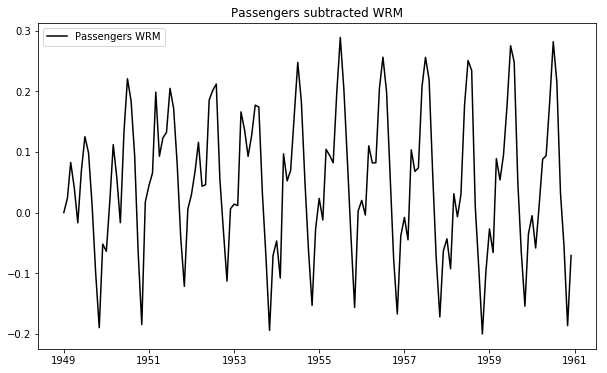

In [14]:
# Subtract the moving average from the original data and plot
subrollingmeanexp = np.log(ts) - rollingmeanexp
subrollingmeanexp.head(10)

fig = plt.figure(figsize=(10,6))
plt.plot(subrollingmeanexp, color='black',label='Passengers WRM')
plt.legend()
plt.title('Passengers subtracted WRM')
plt.show(block=False)

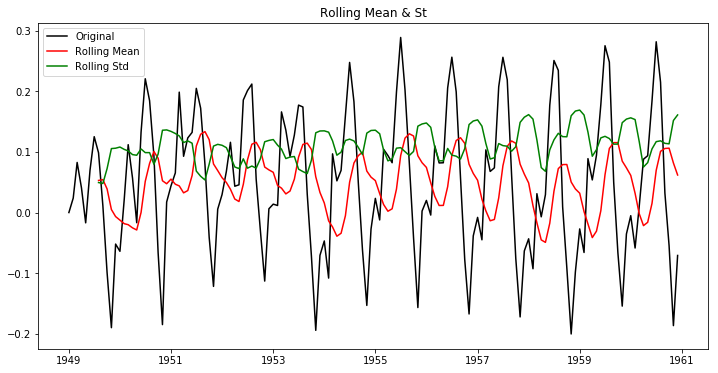

Results of Dickey-Fuller Test:
Test Statistic           -3.297250
p-value                   0.015002
Lags                     13.000000
Observations            130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [16]:
# do a stationarity check
stationarity_check(subrollingmeanexp)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude? 
TheP value is low enough to accept that the data is stationary.


## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [18]:
# difference your data and look at the head
dfdifference = subrollingmeanexp.diff(periods=12)
dfdifference.head(10)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


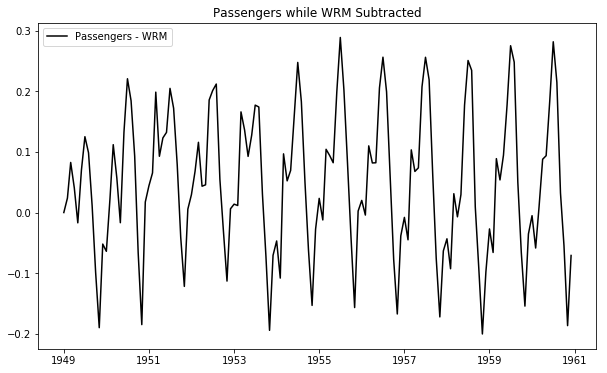

In [19]:
# plot your differenced time series\
fig = plt.figure(figsize=(10,6))
plt.plot(subrollingmeanexp, color='black',label='Passengers - WRM')
plt.legend()
plt.title('Passengers while WRM Subtracted')
plt.show(block=False)

In [20]:
# drop nas
dfdifference.dropna(inplace=True)

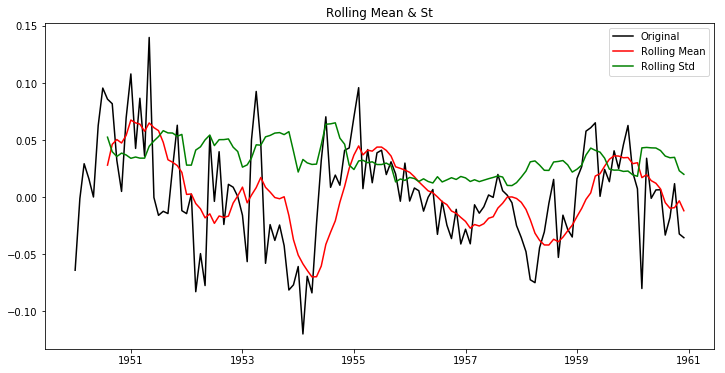

Results of Dickey-Fuller Test:
Test Statistic           -3.601666
p-value                   0.005729
Lags                     12.000000
Observations            119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


In [21]:
# perform the stationarity check
stationarity_check(dfdifference)

### Your conclusion
We have removed season

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.